# Supervised Machine Learning Project
## CUSSON Thomas - MARMORET Axel

In [1]:
# All the needed imports
from os import listdir
from os.path import isfile, join
from sklearn.feature_extraction.text import CountVectorizer
import random
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import KFold

# The differents algorithms
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Load the data

In [2]:
reviewList = []

mydir = "../Datasets/petit/txt_sentoken/" # Could need to change the path

# Load the positive examples 
for txt in listdir(mydir + "pos/"):
    if isfile(join(mydir + "pos/", txt)):
        review = open(join(mydir + "pos/", txt), "r")
        reviews = " ".join(review.readlines()).replace("\n", " ")
        reviewList.append((reviews, 0))
        
# Load the negative examples
for txt in listdir(mydir + "neg/"):
    if isfile(join(mydir + "neg/", txt)):
        review = open(join(mydir + "neg/", txt), "r")
        reviews = " ".join(review.readlines()).replace("\n", " ")
        reviewList.append((reviews, 1))
        

## Pre-format the data

In [3]:
# Shuffle the positive and negative examples
random.seed(42)
random.shuffle(reviewList)

# Use first 70% for training
train_size =int(0.7 * len(reviewList))
train_set, test_set = reviewList[:train_size], reviewList[train_size:]
        
# Split the datasets in usable tables
train_set_unlabeled,train_labels,test_set_unlabeled,test_labels = [], [], [], []

for i in range(len(train_set)) :
    train_set_unlabeled.append(train_set[i][0])
    train_labels.append(train_set[i][1])
for i in range(len(test_set)) :
    test_set_unlabeled.append(test_set[i][0])
    test_labels.append(test_set[i][1])

# Machine Learning algorithms

## Naive Bayes

### Test different parameters

In [4]:
# Pipeline of action specific for the Naive Bayes algorithm
pipeline_nb = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=0.01, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB()),
                    ])

# NB : We have run our algorithm with min_df as a parameter in order to find its best value
# It gaves us 16 in range (1,51,5) and 15 in range (13, 19)
# This parameter exploded our computation time,
# so we decided to fixed it at 1% of our training dataset size (14 here) in order to run our algorithms in decent time

# GridSearch allows us to test severals parameters
parameters_nb = {'vect__ngram_range': [(1, 1), (1, 2)],
                 'tfidf__use_idf': (True, False),
                 'nb__alpha': (1e-1, 1e-2),
}

GridSearchNaiveBayse = GridSearchCV(pipeline_nb, parameters_nb, n_jobs=-1, cv=KFold(n_splits=5, random_state=0), return_train_score=True)

### Run the test pipeline !

In [5]:
GridSearchNaiveBayse = GridSearchNaiveBayse.fit(train_set_unlabeled, train_labels)

### Results from the different parameters

In [6]:
results_naive = GridSearchNaiveBayse.cv_results_

pd.DataFrame(results_naive).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__alpha,param_tfidf__use_idf,param_vect__ngram_range,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.629247,0.194877,0.321389,0.037382,0.1,True,"(1, 1)","{'nb__alpha': 0.1, 'tfidf__use_idf': True, 've...",0.810714,0.782143,...,0.797143,0.013054,5,0.945536,0.952679,0.942857,0.944643,0.950000,0.947143,0.003633
1,3.920712,0.060090,0.449646,0.112610,0.1,True,"(1, 2)","{'nb__alpha': 0.1, 'tfidf__use_idf': True, 've...",0.792857,0.785714,...,0.793571,0.009147,6,0.950000,0.946429,0.943750,0.945536,0.951786,0.947500,0.002956
2,1.208152,0.091369,0.276754,0.038199,0.1,False,"(1, 1)","{'nb__alpha': 0.1, 'tfidf__use_idf': False, 'v...",0.821429,0.782143,...,0.804286,0.013628,2,0.936607,0.949107,0.931250,0.935714,0.939286,0.938393,0.005949
3,4.483519,0.435902,0.617577,0.073933,0.1,False,"(1, 2)","{'nb__alpha': 0.1, 'tfidf__use_idf': False, 'v...",0.828571,0.789286,...,0.808571,0.014214,1,0.941071,0.944643,0.929464,0.936607,0.940179,0.938393,0.005145
4,1.600679,0.285067,0.387498,0.044622,0.01,True,"(1, 1)","{'nb__alpha': 0.01, 'tfidf__use_idf': True, 'v...",0.803571,0.771429,...,0.787857,0.013286,8,0.943750,0.956250,0.943750,0.947321,0.954464,0.949107,0.005297


In [7]:
comparison_results = pd.DataFrame({"rank":results_naive['rank_test_score'],
                                  "alpha":results_naive["param_nb__alpha"],
                                  "tfidf":results_naive["param_tfidf__use_idf"],
                                  "n_gram":results_naive["param_vect__ngram_range"],
                                  "mean_test_score":results_naive["mean_test_score"],
                                  "mean_train_score":results_naive["mean_train_score"]}).set_index("rank")

comparison_results.sort_values('rank', ascending=True)

,alpha,tfidf,n_gram,mean_test_score,mean_train_score
rank,,,,,
1,0.1,False,"(1, 2)",0.808571,0.938393
2,0.1,False,"(1, 1)",0.804286,0.938393
3,0.01,False,"(1, 2)",0.802857,0.943750
4,0.01,False,"(1, 1)",0.800000,0.943929
5,0.1,True,"(1, 1)",0.797143,0.947143
6,0.1,True,"(1, 2)",0.793571,0.947500
7,0.01,True,"(1, 2)",0.789286,0.949643
8,0.01,True,"(1, 1)",0.787857,0.949107


### Looking at the best parameters

In [8]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, GridSearchNaiveBayse.best_params_[param_name]))

print("Best Estimator : " + str(GridSearchNaiveBayse.best_estimator_.get_params()["nb"]))

print("Best Score on those conditions : " + str(GridSearchNaiveBayse.best_score_))

nb__alpha: 0.1
tfidf__use_idf: False
vect__ngram_range: (1, 2)
Best Estimator : MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
Best Score on those conditions : 0.8085714285714286


### Keeping the best estimator according to the parameters

In [9]:
naive = GridSearchNaiveBayse.best_estimator_

### Test the prediction on our test set

Accuracy : 0.815


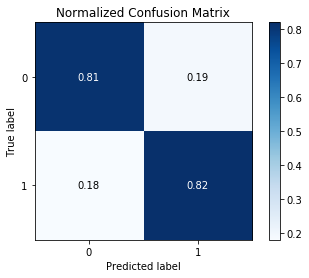

Recall : 0.8104575163398693
Precision : 0.8239202657807309
Under ROC curve area : 0.8150927037481659


In [10]:
test_bayse_prediction = naive.predict(test_set_unlabeled)

print("Accuracy : " + str(metrics.accuracy_score(test_bayse_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_bayse_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_bayse_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_bayse_prediction, test_labels)))
print("Under ROC curve area : " + str(metrics.roc_auc_score(test_bayse_prediction, test_labels)))

## SVM

### We know use the same operating procedure

In [11]:
# Fitting
pipeline_svm = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=0.01, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('svc', SVC()),
                    ])

parameters_svm = {'tfidf__use_idf': (True, False),
                  'vect__ngram_range': [(1, 1), (1, 2)],
                  'svc__kernel': ['linear','rbf'],
                  'svc__gamma': [0.1, 0.01],
                  'svc__C': [10, 100],
}

GridSearchSVM = GridSearchCV(pipeline_svm, parameters_svm, n_jobs=-1, cv=KFold(n_splits=5, random_state=0), return_train_score=True)

GridSearchSVM.fit(train_set_unlabeled, train_labels)

# Get the results
results_SVM = GridSearchSVM.cv_results_

comparison_results = pd.DataFrame({"rank":results_SVM['rank_test_score'],
                                  "kernel":results_SVM["param_svc__kernel"],
                                  "gamma":results_SVM["param_svc__gamma"],
                                  "C":results_SVM["param_svc__C"],
                                  "tfidf":results_SVM["param_tfidf__use_idf"],
                                  "n_gram":results_SVM["param_vect__ngram_range"],
                                  "mean_test_score":results_SVM["mean_test_score"],
                                  "mean_train_score":results_SVM["mean_train_score"]}).set_index("rank")

comparison_results.sort_values('rank', ascending=True)

,kernel,gamma,C,tfidf,n_gram,mean_test_score,mean_train_score
rank,,,,,,,
1,rbf,0.01,100,False,"(1, 2)",0.835714,0.990179
2,rbf,0.1,10,False,"(1, 2)",0.834286,0.991964
3,rbf,0.01,100,True,"(1, 2)",0.830714,0.999107
4,rbf,0.1,10,True,"(1, 1)",0.830000,0.998750
4,rbf,0.1,10,True,"(1, 2)",0.830000,0.999286
4,rbf,0.1,100,True,"(1, 2)",0.830000,1.000000
7,rbf,0.01,100,False,"(1, 1)",0.828571,0.987857
8,rbf,0.1,10,False,"(1, 1)",0.827857,0.990179
9,rbf,0.1,100,False,"(1, 2)",0.825714,1.000000


svc__C: 100
svc__gamma: 0.01
svc__kernel: 'rbf'
tfidf__use_idf: False
vect__ngram_range: (1, 2)
Best Estimator : SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy : 0.8266666666666667


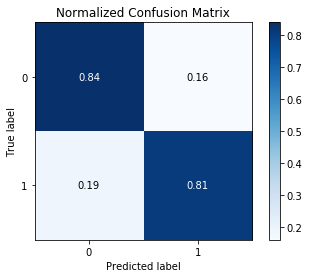

Recall : 0.8361774744027304
Precision : 0.813953488372093
Under ROC curve area : 0.8268835254749808


In [12]:
# Best estimator
for param_name in sorted(parameters_svm.keys()):
    print("%s: %r" % (param_name, GridSearchSVM.best_params_[param_name]))

print("Best Estimator : " + str(GridSearchSVM.best_estimator_.get_params()["svc"]))

svm = GridSearchSVM.best_estimator_

# Prediction on test set
test_svm_prediction = svm.predict(test_set_unlabeled)

# Results
print("\nAccuracy : " + str(metrics.accuracy_score(test_svm_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_svm_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_svm_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_svm_prediction, test_labels)))

print("Under ROC curve area : " + str(metrics.roc_auc_score(test_svm_prediction, test_labels)))

## Random Forest 

In [13]:
# Fitting
pipeline_rf = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=0.01, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('rf', RandomForestClassifier()),
                    ])

parameters_rf = {'tfidf__use_idf': (True, False),
                 'vect__ngram_range': [(1, 1), (1, 2)],
                 'rf__n_estimators': [1000, 2000, 3000],
}

GridSearchRF = GridSearchCV(pipeline_rf, parameters_rf, n_jobs=-1, cv=KFold(n_splits=5, random_state=0), return_train_score=True)

GridSearchRF.fit(train_set_unlabeled, train_labels)

# Get the results
results_RF = GridSearchRF.cv_results_

comparison_results = pd.DataFrame({"rank":results_RF['rank_test_score'],
                                  "n_estimators":results_RF["param_rf__n_estimators"],
                                  "tfidf":results_RF["param_tfidf__use_idf"],
                                  "n_gram":results_RF["param_vect__ngram_range"],
                                  "mean_test_score":results_RF["mean_test_score"],
                                  "mean_train_score":results_RF["mean_train_score"]}).set_index("rank")

comparison_results.sort_values('rank', ascending=True)

,n_estimators,tfidf,n_gram,mean_test_score,mean_train_score
rank,,,,,
1,1000,False,"(1, 2)",0.834286,1.0
2,3000,False,"(1, 2)",0.831429,1.0
3,2000,False,"(1, 2)",0.829286,1.0
4,2000,False,"(1, 1)",0.827857,1.0
5,3000,False,"(1, 1)",0.825000,1.0
6,1000,False,"(1, 1)",0.820714,1.0
7,3000,True,"(1, 2)",0.815714,1.0
8,1000,True,"(1, 2)",0.812857,1.0
9,2000,True,"(1, 2)",0.811429,1.0


rf__n_estimators: 1000
tfidf__use_idf: False
vect__ngram_range: (1, 2)
 Best Estimator : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy : 0.84


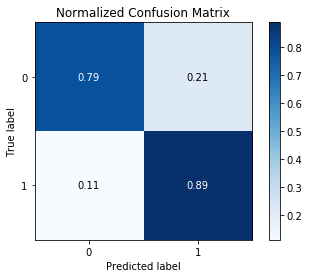

Recall : 0.8096676737160121
Precision : 0.8903654485049833
Under ROC curve area : 0.8434955468951807


In [14]:
# Best estimator
for param_name in sorted(parameters_rf.keys()):
    print("%s: %r" % (param_name, GridSearchRF.best_params_[param_name]))

print(" Best Estimator : " + str(GridSearchRF.best_estimator_.get_params()["rf"]))

rf = GridSearchRF.best_estimator_

# Prediction on test set
test_rf_prediction = rf.predict(test_set_unlabeled)

# Results
print("\nAccuracy : " + str(metrics.accuracy_score(test_rf_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_rf_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_rf_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_rf_prediction, test_labels)))

print("Under ROC curve area : " + str(metrics.roc_auc_score(test_rf_prediction, test_labels)))

## K Nearest Neighbors

In [15]:
# Fitting
pipeline_knn = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=0.01, analyzer = "word")),
                     ('tfidf', TfidfTransformer()),
                     ('knn', KNeighborsClassifier()),
                    ])

parameters_knn = {'tfidf__use_idf': (True, False),
                 'vect__ngram_range': [(1, 1), (1, 2)],
                 'knn__p': [1,2],
                 'knn__n_neighbors': [25,50,100],
}

GridSearchKNN = GridSearchCV(pipeline_knn, parameters_knn, n_jobs=-1, cv=KFold(n_splits=5, random_state=0), return_train_score=True)

GridSearchKNN.fit(train_set_unlabeled, train_labels)

# Get the results
results_KNN = GridSearchKNN.cv_results_

comparison_results = pd.DataFrame({"rank":results_KNN['rank_test_score'],
                                  "p":results_KNN["param_knn__p"],
                                  "n_neighbors":results_KNN["param_knn__n_neighbors"],
                                  "tfidf":results_KNN["param_tfidf__use_idf"],
                                  "n_gram":results_KNN["param_vect__ngram_range"],
                                  "mean_test_score":results_KNN["mean_test_score"],
                                  "mean_train_score":results_KNN["mean_train_score"]}).set_index("rank")

comparison_results.sort_values('rank', ascending=True)

,p,n_neighbors,tfidf,n_gram,mean_test_score,mean_train_score
rank,,,,,,
1,2,100,True,"(1, 1)",0.745000,0.756964
2,2,100,True,"(1, 2)",0.740000,0.759107
3,2,50,True,"(1, 2)",0.730000,0.753214
3,2,50,True,"(1, 1)",0.730000,0.755000
5,2,50,False,"(1, 2)",0.700714,0.716250
6,2,50,False,"(1, 1)",0.692857,0.714107
7,2,25,True,"(1, 2)",0.688571,0.741964
8,2,25,True,"(1, 1)",0.687857,0.745536
9,2,25,False,"(1, 1)",0.682857,0.731786


knn__n_neighbors: 100
knn__p: 2
tfidf__use_idf: True
vect__ngram_range: (1, 1)
 Best Estimator : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

Accuracy : 0.7616666666666667


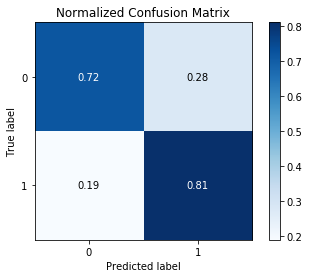

Recall : 0.7408536585365854
Precision : 0.8073089700996677
Under ROC curve area : 0.763809182209469


In [19]:
# Best estimator
for param_name in sorted(parameters_knn.keys()):
    print("%s: %r" % (param_name, GridSearchKNN.best_params_[param_name]))

print(" Best Estimator : " + str(GridSearchKNN.best_estimator_.get_params()["knn"]))

knn = GridSearchKNN.best_estimator_

# Prediction on test set
test_knn_prediction = knn.predict(test_set_unlabeled)

# Results
print("\nAccuracy : " + str(metrics.accuracy_score(test_knn_prediction, test_labels)))

skplt.metrics.plot_confusion_matrix(test_labels, test_knn_prediction, normalize=True)
plt.show()

print("Recall : " + str(metrics.recall_score(test_knn_prediction, test_labels)))
print("Precision : " + str(metrics.precision_score(test_knn_prediction, test_labels)))

print("Under ROC curve area : " + str(metrics.roc_auc_score(test_knn_prediction, test_labels)))

# Compare the results

### Accuracy comparison

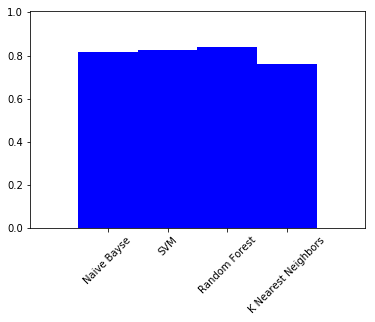

In [17]:
x = [1, 2, 3, 4]
y = [metrics.accuracy_score(test_bayse_prediction, test_labels),
     metrics.accuracy_score(test_svm_prediction, test_labels),
     metrics.accuracy_score(test_rf_prediction, test_labels),
     metrics.accuracy_score(test_knn_prediction, test_labels)
]

labels = ['Naive Bayse', 'SVM', 'Random Forest', 'K Nearest Neighbors']

bar_width = 1.0 

plt.xticks(x, labels, rotation=45)

plt.margins(0.2)
plt.bar(x, y, bar_width, color='blue')
plt.show()

### Text Analysis

In [18]:
# Get all the words
words = naive.get_params()["vect"].get_feature_names()

# Number of times each word appears in all the positive messages
pos_word_count = naive.get_params()["nb"].feature_count_[0, :]

neg_word_count = naive.get_params()["nb"].feature_count_[1, :]

ratio_pos_neg = []
for i in range(len(pos_word_count)) :
    ratio_pos_neg.append(pos_word_count[i]/neg_word_count[i])

words_frequencies = pd.DataFrame({"word":words, "positive":pos_word_count, "negative":neg_word_count, "ratio":ratio_pos_neg}).set_index("word")

words_frequencies.sort_values('ratio', ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


,positive,negative,ratio
word,,,
chilling,0.672439,0.000000,inf
gripping,0.783932,0.000000,inf
edition,0.954340,0.025959,36.763776
magnificent,0.912128,0.035355,25.798879
fictional,0.790032,0.046829,16.870471
coen,1.377167,0.100868,13.653226
imaginative,0.830720,0.069750,11.909947
wonderfully,2.160436,0.186956,11.555840
maintains,0.677545,0.060971,11.112568
